(70037, 1)
Dataset mean =  0.5363373411352942 var =  0.01966813341576947
Maximum value =  [37.28]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 24, 1)        0                                            
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 24, 32)       2304        input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (None, 24, 32)       6272        bidirectional_12[0][0]           
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 24, 33)       0           bidirectional_13[0][0]           
           

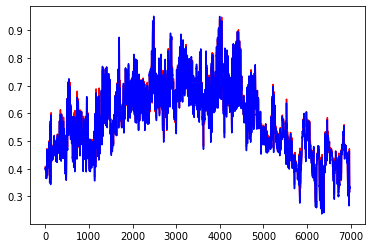

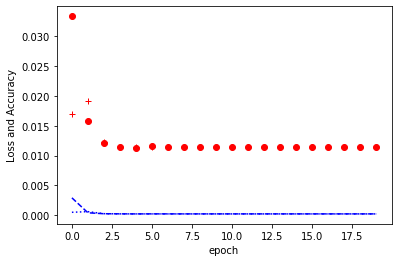

Test Score > MSE ==  0.000227634036624853  MAE ==  0.010977959787014156 MAPE ==  2.004125963281828


In [2]:
import pandas as pd
import tensorflow as tf
import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import keras
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import merge
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Add
from keras.layers import Activation, BatchNormalization, regularizers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers import LSTM, Bidirectional
from keras.utils import plot_model
from keras.layers import Dropout
from scipy import signal
import openpyxl

from keras.backend import tensorflow_backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

class LossHistory(keras.callbacks.Callback):  # history = LossHistory()
    def init(self):  # history.init()
        self.losses = []
        # self.accs = []
        self.val_losses = []
        # self.val_accs = []
        self.mses = []
        self.maes = []
        self.mapes = []
        self.val_mses = []
        self.val_maes = []
        self.val_mapes = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # self.accs.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        # self.val_accs.append(logs.get('val_accuracy
        self.mses.append(logs.get('mean_squared_error'))
        self.maes.append(logs.get('mean_absolute_error'))
        self.mapes.append(logs.get('mean_absolute_percentage_error'))
        self.val_mses.append(logs.get('val_mean_squared_error'))
        self.val_maes.append(logs.get('val_mean_absolute_error'))
        self.val_mapes.append(logs.get('val_mean_absolute_percentage_error'))

def create_dataset(dataset, timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps - 1):
        a = dataset[i:(i + timesteps), 0]
        dataX.append(a)
        dataY.append(dataset[i + timesteps, 0])
    return np.array(dataX), np.array(dataY)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

data_path = 'C:/Users/Smartgrid_ML/Desktop/KMS/climate_hour.csv'
data_source = pd.read_csv(data_path)
data_source = pd.DataFrame(data_source)
data_set = data_source.iloc[:, 2]
data = np.array(data_set)
data = data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
Maxvalue_1 = scaler.data_max_
print(data.shape)

Tr_mean = np.nanmean(data)
Tr_var = np.nanvar(data)

print('Dataset mean = ', Tr_mean, 'var = ', Tr_var)
print('Maximum value = ', Maxvalue_1)

Training_set = data[0:42022, :]
Validation_set = data[42023:63031, :]
Test_set = data[63032:, :]

features = 1
timesteps = 24
trainX, trainY = create_dataset(Training_set, timesteps)
validX, validY = create_dataset(Validation_set, timesteps)
testX, testY = create_dataset(Test_set, timesteps)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = np.reshape(validX, (validX.shape[0], validX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# -----------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------
visible1 = Input(shape=(timesteps, features))

bi11 = (Bidirectional(LSTM(16, return_sequences=True)))(visible1)  ### success
bi12 = (Bidirectional(LSTM(16, return_sequences=True)))(bi11)
res13 = keras.layers.Concatenate()([bi12, visible1])

bi13 = (Bidirectional(LSTM(16, return_sequences=True)))(res13)
bi14 = (Bidirectional(LSTM(16, return_sequences=True)))(bi13)
res14 = keras.layers.Concatenate()([bi14, res13, visible1])

bi15 = (Bidirectional(LSTM(16, return_sequences=True)))(res14)
bi16 = (Bidirectional(LSTM(16, return_sequences=True)))(bi15)
res15 = keras.layers.Concatenate()([bi16, res13, res14, visible1])

bi17 = (Bidirectional(LSTM(16, return_sequences=True)))(bi16)
bi18 = (Bidirectional(LSTM(16, return_sequences=True)))(bi17)
res16 = keras.layers.Concatenate()([bi18, res13, res14, res15, visible1])

bi19 = (Bidirectional(LSTM(16, return_sequences=True)))(res16)
bi20 = (Bidirectional(LSTM(16, return_sequences=True)))(bi19)
res17 = keras.layers.Concatenate()([bi20, res13, res14, res15, res16, visible1])

bi21 = (Bidirectional(LSTM(32)))(res17)

dense11 = Dense(24, activation='selu')(bi21)
out1 = Dense(1, activation='selu')(dense11)

model = Model(inputs=[visible1], outputs=[out1])  # multi-input, multi-output

#########################################

print(model.summary())

reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)  # 에포크 1동안 좋아지지 않으면 호출

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])

batch_size = 100
epochs = 20

history = LossHistory()
history.init()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(validX, validY), callbacks=[history, reducelr])  # , checkpoint

trainPredict = model.predict(trainX, batch_size=batch_size)
validPredict = model.predict(validX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)

trainPredict = trainPredict.reshape([-1])
validPredict = validPredict.reshape([-1])
testPredict = testPredict.reshape([-1])
testY = testY.reshape([-1])
validY = validY.reshape([-1])
trainY = trainY.reshape([-1])

np.savetxt('trainPredict_5.txt', trainPredict)
np.savetxt('testPredict_5.txt', testPredict)
np.savetxt('validPredict_5.txt', validPredict)
np.savetxt('testY_5.txt', testY)
np.savetxt('validY_5.txt', validY)
np.savetxt('trainY_5.txt', trainY)

print('--------------------------------------------------------')
print(' history.mses(=loss) = ', history.mses)  # loss == mse
print(' history.maes        = ', history.maes)
print(' history.mapes        = ', history.mapes)
print(' history.val_mses(=loss)= ', history.val_mses)  # loss == mse
print(' history.val_maes       = ', history.val_maes)
print(' history.val_mapes       = ', history.val_mapes)
print('--------------------------------------------------------')

plt.figure(1)
plt.plot(testPredict, 'r')
plt.plot(testY, 'b')
plt.show()

plt.figure(2)
plt.plot(history.mses, 'b--')
plt.plot(history.val_mses, 'b:')
plt.plot(history.maes, 'ro')
plt.plot(history.val_maes, 'r+')
plt.ylabel('Loss and Accuracy')
plt.xlabel('epoch')
plt.show()

print('Test Score > MSE == ', mean_squared_error(testY, testPredict), ' MAE == ', mean_absolute_error(testY, testPredict), 'MAPE == ', mean_absolute_percentage_error(testY, testPredict))